### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions
using MDToolbox

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [4]:
#二原子のトラジェクトリからFを計算
function compute_free_energy(coords1_trj, coords2_trj, beta, epsilon, sigma)
    N = size(coords1_trj, 1)
    U_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in zip(coords1_trj, coords2_trj)]
    #F = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* U_array)))
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array))
    return F
end

compute_free_energy (generic function with 1 method)

In [5]:
# exponential averaging
function compute_deltaF(coords_trj , beta, epsilon, sigma, U_array)
    N = size(coords_trj, 1)
    U_target_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in coords_trj]
    deltaU = U_target_array .- U_array
    #@show deltaU
    #deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

In [6]:
function compute_distance(coords1, coords2)
    r = sqrt(sum((coords1 .- coords2).^2))
    return r
end

compute_distance (generic function with 1 method)

### MCMCの定義

In [7]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-1)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

next_coords (generic function with 2 methods)

In [8]:
#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        next_U = compute_energy(next_coords1, next_coords2, epsilon, sigma)
        current_U = compute_energy(coords1, coords2, epsilon, sigma)
        delta_U = next_U - current_U
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    return coords1_trj, coords2_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### ΔFを求める

In [9]:
kBT = 0.1
beta = 1.0/(kBT)
nstep = 1000000

K = 2

epsilon = Vector{Float64}(undef, K)
sigma = Vector{Float64}(undef, K)

epsilon[1] = 1.0
sigma[1] = 4.0

epsilon[2] = 1.2
sigma[2] = 4.2

trj1 = Vector{Any}(undef, K)
trj2 = Vector{Any}(undef, K)
for k = 1:K
    trj1[k], trj2[k], alpha = mcmc(rand(3), rand(3), epsilon[k], sigma[k], nstep, beta)
end

In [10]:
u_kl = Array{Any}(undef, (K, K))

for k = 1:K
    for l = 1:K
        u_kl[k, l] = map(x -> beta * compute_energy(x[1], x[2], epsilon[l], sigma[l]), zip(trj1[k], trj2[k]))
    end
end

In [11]:
f_k = mbar(u_kl)
(1 ./ beta) .* f_k

iteration = 1  delta = 1.414214e+00  tol = 1.000000e-08
free energies =  0.000000 -1.319523

iteration = 2  delta = 3.883222e-01  tol = 1.000000e-08
free energies =  0.000000 -1.818991

iteration = 3  delta = 1.100088e-01  tol = 1.000000e-08
free energies =  0.000000 -1.972422

iteration = 4  delta = 2.982947e-02  tol = 1.000000e-08
free energies =  0.000000 -2.014922

iteration = 5  delta = 7.936902e-03  tol = 1.000000e-08
free energies =  0.000000 -2.026294

iteration = 6  delta = 2.099870e-03  tol = 1.000000e-08
free energies =  0.000000 -2.029307

iteration = 7  delta = 5.547031e-04  tol = 1.000000e-08
free energies =  0.000000 -2.030103

iteration = 8  delta = 1.464703e-04  tol = 1.000000e-08
free energies =  0.000000 -2.030314

iteration = 9  delta = 3.867150e-05  tol = 1.000000e-08
free energies =  0.000000 -2.030369

iteration = 10  delta = 1.020987e-05  tol = 1.000000e-08
free energies =  0.000000 -2.030384

iteration =11  delta = 3.662488e-07  tol = 1.000000e-08
free energies

2-element Vector{Float64}:
  0.0
 -0.20303889561310623

In [12]:
epsilon_target = 1.1
sigma_target = 4.1

trj1_target, trj2_target, alpha = mcmc(rand(3), rand(3), epsilon_target, sigma_target, nstep, beta);

### 距離を計算

In [13]:
@show r1 = mean(compute_distance.(trj1[1], trj2[1])) 
@show r_target = mean(compute_distance.(trj1_target, trj2_target))

r1 = mean(compute_distance.(trj1[1], trj2[1])) = 4.091453570543749
r_target = mean(compute_distance.(trj1_target, trj2_target)) = 4.184115601908575


4.184115601908575

In [14]:
# Sanity check
u_k = Vector{Any}(undef, K)

for k = 1:K
    u_k[k] = map(x -> beta * compute_energy(x[1], x[2], epsilon_target, sigma_target), zip(trj1[k], trj2[k])) #あとでチェック
end

#f_target = mbar_f(u_kl, f_k, u_k)

weight_target = mbar_weight(u_kl, f_k, u_k)

r = Vector{Float64}(undef, K)
for k = 1:K
    r[k] = sum(compute_distance.(trj1[k], trj2[k]) .* weight_target[k])
end
@show r_target = mean(compute_distance.(trj1_target, trj2_target))
@show sum(r)

r_target = mean(compute_distance.(trj1_target, trj2_target)) = 4.184115601908575
sum(r) = 4.183796745407699


4.183796745407699

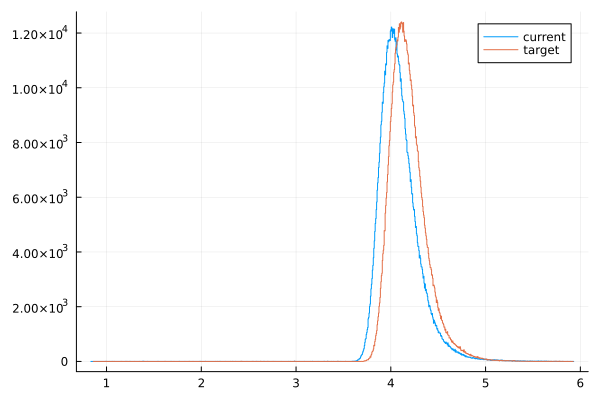

In [15]:
k = 1
r = compute_distance.(trj1[k], trj2[k])
histogram(r,label="current")
r = compute_distance.(trj1_target, trj2_target)
histogram!(r,label="target")

In [16]:
#パラメータ推定に用いる原子の軌跡と距離の平均
X_train = []
for k = 1:K
    push!(X_train, (trj1[k], trj2[k]))
end
y_train = r_target

4.184115601908575

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [17]:
function compute_weighted_distance(X, f_k, u_kl, beta, epsilon, sigma)
    #K = length(f_k)
    #u_k = Vector{Vector{Float64}}(undef, 0)
    #for k = 1:K
        #for istep = 1:nstep
        #    u_k[k][istep] = beta * compute_energy(X[1][k][istep], X[2][k][istep], m.P[1], m.P[2])
        #end
        #push!(u_k, map(x -> beta * compute_energy(x[1], x[2], epsilon, sigma), zip(X[1][k], X[2][k])))
    #end
    u_k = map(XX -> map(x -> beta * compute_energy(x[1], x[2], epsilon, sigma), zip(XX[1], XX[2])), X)
    weight_target = mbar_weight(u_kl, f_k, u_k)
    #r = Vector{Float64}(undef, K)
    #for k = 1:K
        #r[k] = sum(compute_distance.(trj1[k], trj2[k]) .* weight_target[k])
    #end
    weighted_distance = sum([sum(compute_distance.(trj1[k], trj2[k]) .* weight_target[k]) for k in 1:K])
    return weighted_distance
end

compute_weighted_distance (generic function with 1 method)

In [18]:
struct MBAR
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor MBAR (P,)

(m::MBAR)(X) = compute_weighted_distance(X, f_k, u_kl, beta, m.P[1], m.P[2])

In [19]:
# Sanity check
m = MBAR([epsilon_target, sigma_target])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

1.0166946815062975e-7

In [20]:
m = MBAR([epsilon[2], sigma[2]])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

0.008327980068251726

In [27]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-2)

Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [28]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [29]:
loss_train = []

for epoch in 1:20
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    L = loss(X_train, y_train)
    push!(loss_train, L)
    print_callback(epoch, L, ps)
end

Epoch: 1, loss: 0.00155514558643651
param: [1.1438133124754073, 4.143651804404615]
Epoch: 2, loss: 0.0009235379544963057
param: [1.1339231710631563, 4.1337580470905735]
Epoch: 3, loss: 0.00046491405027761896
param: [1.124259186439444, 4.124084566115819]
Epoch: 4, loss: 0.00017151790687819463
param: [1.114982443784252, 4.11479112167377]
Epoch: 5, loss: 2.6890506362869846e-5
param: [1.106304863505564, 4.106090453574205]
Epoch: 6, loss: 3.752354212249831e-6
param: [1.0984821856497369, 4.0982425690586215]
Epoch: 7, loss: 6.437808602630886e-5
param: [1.0917836405543073, 4.091524673409243]
Epoch: 8, loss: 0.00016542348592580517
param: [1.08643829323582, 4.086175438411425]
Epoch: 9, loss: 0.00026661371245922905
param: [1.082579447887581, 4.082335530519448]
Epoch: 10, loss: 0.00033910044664378554
param: [1.0802185116749183, 4.080018655751983]
Epoch: 11, loss: 0.0003691174983871815
param: [1.0792595029423275, 4.07912631088063]
Epoch: 12, loss: 0.00035634942942536153
param: [1.0795366730160387, 

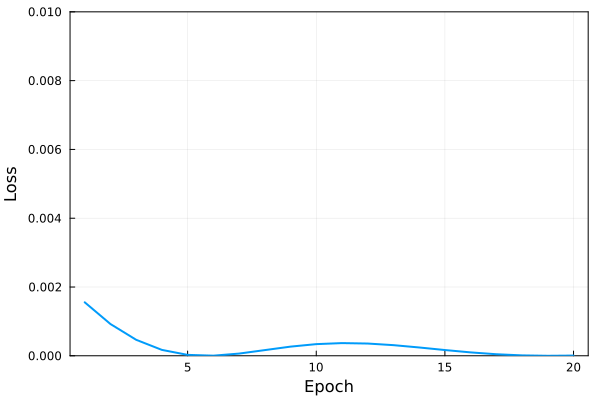

In [30]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, ylims=(0.0, 0.01))
ylabel!("Loss")
xlabel!("Epoch")

In [31]:
println("Initial epsilon:   ", epsilon[2])
println("Estimated epsilon: ", m.P[1])
println("Target epsilon:    ", epsilon_target)
println()
println("Initial sigma:   ", sigma[2])
println("Estimated sigma: ", m.P[2])
println("Target sigma:    ", sigma_target)

Initial epsilon:   1.2
Estimated epsilon: 1.1023065133650043
Target epsilon:    1.1

Initial sigma:   4.2
Estimated sigma: 4.103048403270639
Target sigma:    4.1
